In [270]:
from pvlib.iotools import get_pvgis_hourly

import pandas as pd
import datetime
import pytz

In [271]:
location = {'latitude': 52.021111, 'longitude': 8.534722}
yearlyConsumptionHousehold = 3400
yearlyConsumptionHeatpump = 2800

In [272]:
arrays = [
    {
        'surfaceTilt': 30,
        'surfaceAzimuth': -155,
        'peakPower': 340*17/1000,
        'name': 'North-East-Facing Array'
    },
    {
        'surfaceTilt': 30,
        'surfaceAzimuth': 25,
        'peakPower': 340*8/1000,
        'name': 'South-West-Facing Array'
    }
]

In [273]:
pvPower = [None] * len(arrays)
for idx, array in enumerate(arrays):
    pvPower[idx], _, _ = get_pvgis_hourly(location['latitude'], location['longitude'],
                                            surface_tilt=array['surfaceTilt'],
                                            surface_azimuth=array['surfaceAzimuth'],
                                            peakpower=array['peakPower'],
                                            pvcalculation=True,
                                            mountingplace='building',
                                            loss=14,
                                            url="https://re.jrc.ec.europa.eu/api/v5_2/",
                                            start=2019,
                                            end=2019
                                           )

In [274]:
battery = {
    "socMax": 10240,
    "socMin": 10240*0.05
}

In [275]:
pvPowerCombined = sum(pvPower)
# PVGIS results have a shift after the full hour, so we shift them back to the hour
# That shift is somehow dependent on the location, but I don't yet understand how,
# that why we try to guess the shift from the first entry
shift = pvPowerCombined.index[0] - datetime.datetime(2019, 1, 1, tzinfo=pytz.utc)
pvPowerCombined = pvPowerCombined.shift(-int(shift.total_seconds()/60), freq='min')

In [276]:
hdf = pd.HDFStore('2019_data_spatial.hdf5', mode='r')
# Rescale load to our usage defined above
householdLoad = hdf.get('/NO_PV/60min/HOUSEHOLD')*yearlyConsumptionHousehold*1000/hdf.get('/NO_PV/60min/HOUSEHOLD').P_TOT.sum() + hdf.get('/NO_PV/60min/HEATPUMP')*yearlyConsumptionHeatpump*1000/hdf.get('/NO_PV/60min/HEATPUMP').P_TOT.sum()
# Add UTC timezone to allow merging the dataframe with the PVGIS dataframe
householdLoad.index = householdLoad.index.tz_localize('UTC')

In [277]:
combinedDataframe = pd.concat([pvPowerCombined, householdLoad], axis=1)
combinedDataframe.rename(columns={'P_TOT': 'householdLoad', 'P': 'PV'}, inplace=True)

In [278]:
outputDataframe = combinedDataframe[['householdLoad', 'PV']]
outputDataframe = outputDataframe.assign(selfUsage=0., batteryDischarge=0., gridFeed=0., gridUsage=0., batteryChargeLevel=0., )
outputDataframe.head()

,householdLoad,PV,selfUsage,batteryDischarge,gridFeed,gridUsage,batteryChargeLevel
2019-01-01 00:00:00+00:00,869.867054,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 01:00:00+00:00,737.934386,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 02:00:00+00:00,723.909549,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 03:00:00+00:00,730.378276,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 04:00:00+00:00,704.578084,0.0,0.0,0.0,0.0,0.0,0.0


In [279]:
for time, row in combinedDataframe.iterrows():
    PV_power = row.PV
    load = row.householdLoad
    # Get battery charge from last row
    current_row_int_index = outputDataframe.index.get_loc(time)
    battery_charge = outputDataframe['batteryChargeLevel'].iloc[current_row_int_index - 1]
    
    if (PV_power >= load):
        # Cover load from PV
        excess_power = PV_power - load
        outputDataframe.at[time, 'selfUsage'] = load
        # Distribute excess power, load battery first
        battery_charge += excess_power
        if battery_charge >= battery['socMax']:
            # battery would be overcharged, feed what would not fit into the grid
            battery_overcharge = battery_charge - battery['socMax']
            outputDataframe.at[time, 'gridFeed'] = battery_overcharge
            # reduce battery charge to battery capacity
            battery_charge = battery['socMax']

    elif (PV_power < load):
        # Use PV to partially cover load
        excess_load = load - PV_power
        outputDataframe.at[time, 'selfUsage'] = PV_power
        # Try to cover the rest of the load from the battery
        battery_charge -= excess_load
        if battery_charge < battery['socMin']:
            # calculate load to be covered by the grid
            grid_load = battery['socMin'] - battery_charge
            # Cover excess load from the grid
            outputDataframe.at[time, 'gridUsage'] = grid_load
            # reduce excess_load for battery discharge calculation
            excess_load -= grid_load
            # reset battery charge to socMin
            battery_charge = battery['socMin']
        # note battery discharge to cover load
        outputDataframe.at[time, 'batteryDischarge'] = excess_load
    
    # Write new battery charge to the output dataframe
    outputDataframe.at[time, 'batteryChargeLevel'] = battery_charge

In [280]:
householdConsumption = outputDataframe.householdLoad.sum()/1000
pvPower = outputDataframe.PV.sum()/1000
selfUsage = outputDataframe.selfUsage.sum()/1000
batteryDischarge = outputDataframe.batteryDischarge.sum()/1000
gridUsage = outputDataframe.gridUsage.sum()/1000
gridFeed = outputDataframe.gridFeed.sum()/1000

print(f'Household power consumption: {householdConsumption:.0f} kWh')
print(f'Solar power: {pvPower:.0f} kWh')
print(f'direct self usage: {selfUsage:.0f} kWh / {selfUsage*100/pvPower:.1f} %')
print(f'battery discharge: {batteryDischarge:.0f} kWh / {batteryDischarge*100/pvPower:.1f} %')
print(f'grid feed: {gridFeed:.0f} kWh / {gridFeed*100/pvPower:.1f} %')

Household power consumption: 6200 kWh
Solar power: 6043 kWh
direct self usage: 2037 kWh / 33.7 %
battery discharge: 1258 kWh / 20.8 %
grid feed: 2748 kWh / 45.5 %


<AxesSubplot:ylabel='Battery Charge'>

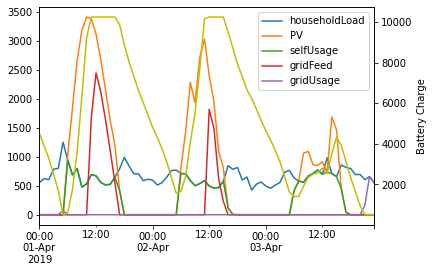

In [281]:
dateFrom = '2019-04-01'
dateUntil = '2019-04-03'
ax_power = outputDataframe[['householdLoad', 'PV', 'selfUsage', 'gridFeed', 'gridUsage']].loc[dateFrom:dateUntil].plot()

ax_battery = ax_power.twinx()
ax_battery.set_ylabel('Battery Charge')
ax_battery.spines['right'].set_position(('axes', 1.0))
outputDataframe['batteryChargeLevel'].loc[dateFrom:dateUntil].plot(ax=ax_battery, style='y-')